In [1]:
DATA_PATH = '../new-data-without_silence'
TRAIN_DATA_PATH = f'{DATA_PATH}/train'
TASK_DATA_PATH = f'{DATA_PATH}/test'
TRAIN_FILENAME = f'{DATA_PATH}/train_gt.csv'
TASK_FILENAME = f'{DATA_PATH}/test.csv'

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

df = pd.read_csv(TRAIN_FILENAME, header=None, names=['audio', 'label'])
df['audio'] = TRAIN_DATA_PATH + "/" + df['audio']

x, y = df['audio'], df['label'].to_numpy().reshape(-1, 1)

weight_for_0 = (1 / (len(y) - np.sum(y))) * (len(y) / 2.0)
weight_for_1 = (1 / np.sum(y)) * (len(y) / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 0.7903573352486982, 1: 1.3610080395794681}


/opt/miniconda3/envs/mfcc-cnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#from rnnoise_wrapper import RNNoise
from pydub import AudioSegment
import python_speech_features as psf


def preprocess_function(audio_path):
    segment = AudioSegment.from_mp3(audio_path)

    inputs = psf.mfcc(
        np.array(segment.get_array_of_samples()), segment.frame_rate,
        numcep=128
    )

    return inputs

In [4]:
# features_list = []

# for audio in tqdm(x):
#     features_list.append(preprocess_function(audio))

# # # # #features_list = pad_each(features_list)

# # # # #X = np.stack(features_list)

In [5]:
# np.save("train", X)

In [6]:
MAX = 100

In [7]:
X = np.load('train.npy').astype(float)

In [8]:
X /= MAX

In [9]:
# import tensorflow as tf
# X = tf.keras.utils.pad_sequences(features_list, padding='post')

In [10]:
diff = len(y) - sum(y) - sum(y)

indexes = []

for ind, i in enumerate(y):
    if i == 0:
        diff -= 1
        indexes.append(ind)
        if diff == 0:
            break
X = np.delete(X, indexes, axis=0)
y = np.delete(y, indexes, axis=0)

In [11]:
X.shape, y.shape

((6468, 3869, 26), (6468, 1))

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Относительное количество положительный записей')
print(f'Вся выборка: {sum(y) / len(y)}')
print(f'Обучающая выборка: {sum(y_train) / len(y_train)}')
print(f'Валидационная выборка: {sum(y_test) / len(y_test)}')

Относительное количество положительный записей
Вся выборка: [0.5]
Обучающая выборка: [0.49569251]
Валидационная выборка: [0.51004637]


In [13]:
import logging
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, callbacks, models, callbacks
from tensorflow_models import nlp
from maximal.layers import Attention

logging.basicConfig(level=logging.INFO)

In [14]:
class MyModel(models.Model):
    def __init__(self, kernel_size, num_classes, dropout=0.1):
        super().__init__()
        # Convolutional encoder
        self.conv = self.conv = models.Sequential([
            # (3, 3) kernel size
            layers.Conv1D(32, kernel_size=kernel_size, activation='relu'),
            layers.MaxPooling1D(pool_size=kernel_size),
            layers.Conv1D(32, kernel_size=kernel_size, activation='relu'),
            layers.MaxPooling1D(pool_size=kernel_size),
            #layers.Dropout(dropout),
            # (2, 2) kernel size
            layers.Conv1D(64, kernel_size=kernel_size, activation='relu'),
            layers.MaxPooling1D(pool_size=kernel_size), 
            layers.Conv1D(128, kernel_size=kernel_size, activation='relu'),
            layers.MaxPooling1D(pool_size=kernel_size), 
            layers.Conv1D(256, kernel_size=kernel_size, activation='relu'),
            layers.MaxPooling1D(pool_size=kernel_size), 
        ], name='conv')

        # Attention
        self.attention = layers.Attention()

        # GlobalAveragePoolings
        self.gap_attention = layers.GlobalAveragePooling1D()
        self.gap_input = layers.GlobalAveragePooling1D()

        # Add attention
        self.apply_attention = layers.Concatenate()

        # Classification Head
        self.classification_head = models.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dropout(dropout),
            layers.Dense(64, activation='relu'),
            layers.Dropout(dropout),
            layers.Dense(16, activation='relu'),
            layers.Dropout(dropout),
            layers.Dense(4, activation='relu'),
            layers.Dropout(dropout),
            layers.Dense(num_classes, activation='sigmoid'),
        ], name='classification_head')

    def call(self, x):
        # Convolutional encoder
        x = self.conv(x)
        logging.debug(f'{x.shape=} after conv')

        # Getting attention
        attention = self.attention([x, x])
        logging.debug(f'{attention.shape=}')

        # GAPing
        attention = self.gap_attention(attention)
        x = self.gap_input(x)
        logging.debug(f'after GAP {attention.shape=} {x.shape=}')

        # Apply attention
        x = self.apply_attention([x, attention])
        logging.debug(f'{x.shape=} after attention')
        
        # Classification
        x = self.classification_head(x)

        return x

model = MyModel(
    kernel_size=3,
    num_classes=1,
    dropout=0.3
)

# model.summary()

2024-08-23 01:15:44.785851: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-23 01:15:44.785873: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-23 01:15:44.785876: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-23 01:15:44.785891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-23 01:15:44.785901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.8)

custom_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=3e-3,
        patience=15,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        filepath='./saves/rnn_mfcc.weights.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
        save_weights_only=True
    )
]

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        'accuracy', 
        tf.keras.metrics.F1Score(average='macro', threshold=0.5),
        tf.keras.metrics.Precision(),  # correct 1 / all predicted as 1
        tf.keras.metrics.Recall()  # correct 1 / all 1
    ]
)

hist = model.fit(
    X_train, y_train,
    epochs=30,
    callbacks=custom_callbacks,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
#    class_weight=class_weight
)

Epoch 1/30


2024-08-23 01:15:48.081500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.4873 - f1_score: 0.3539 - loss: 0.6932 - precision: 0.4666 - recall: 0.3309 - val_accuracy: 0.5100 - val_f1_score: 0.6755 - val_loss: 0.6931 - val_precision: 0.5100 - val_recall: 1.0000
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.5039 - f1_score: 0.6402 - loss: 0.6932 - precision: 0.5032 - recall: 0.8952 - val_accuracy: 0.4900 - val_f1_score: 0.0000e+00 - val_loss: 0.6935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.5070 - f1_score: 0.0000e+00 - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4900 - val_f1_score: 0.0000e+00 - val_loss: 0.6933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.5085 - f1_score: 0.0013 - loss: 0.6931 - precision: 0.0220 - recall: 6.5185e-04 - val_accuracy: 0.5100 - val_f1_score: 0.6755 - val_loss: 0.6931 - v

In [16]:
import matplotlib
%matplotlib inline

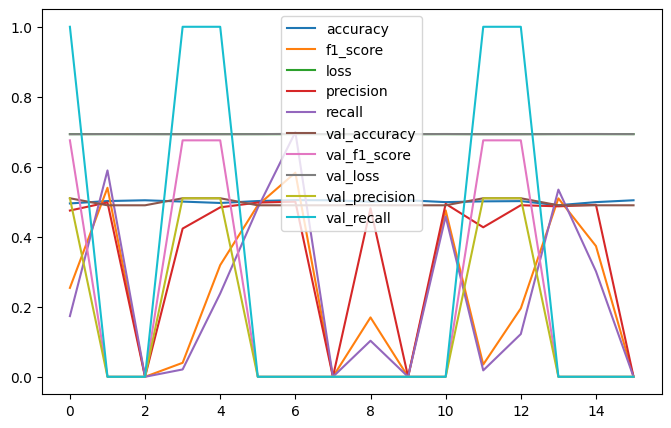

In [17]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.show()

In [32]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv (Sequential)               │ (None, 14, 256)        │       135,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate (Concatenate)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head             │ (None, 1)              │       148,889 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,988 (2.17 MB)

 Trainable params: 283,993 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 283,995 (1.08 MB)

In [33]:
model.load_weights('./saves/rnn_mfcc.weights.h5')

In [34]:
pred = model.predict(X)
print(np.sum(pred) / len(pred))
model.evaluate(X, y, return_dict=True)

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
0.5015907641465677
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6983 - f1_score: 0.8091 - loss: 0.6919 - precision: 0.6983 - recall: 1.0000


{'accuracy': 0.5,
 'f1_score': 0.6666666269302368,
 'loss': 0.6931518316268921,
 'precision': 0.5,
 'recall': 1.0}

In [35]:
pred = model.predict(X_test)
print(np.sum(pred) / len(pred))
model.evaluate(X_test, y_test, return_dict=True)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
0.5015907503783488
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5215 - f1_score: 0.6854 - loss: 0.6930 - precision: 0.5215 - recall: 1.0000


{'accuracy': 0.5100463628768921,
 'f1_score': 0.6755372881889343,
 'loss': 0.6930882334709167,
 'precision': 0.5100463628768921,
 'recall': 1.0}

In [36]:
model.save('saves/rnn_mfcc.keras')

## Task

In [37]:
task = pd.read_csv(TASK_FILENAME, header=None, names=['audio', 'label'])
task['audio'] = TASK_DATA_PATH + "/" + task['audio']

task_x = task['audio']

In [24]:
# task_features_list = []

# for audio in tqdm(task_x):
#     task_features_list.append(preprocess_function(audio))

In [25]:
# task_X = tf.keras.utils.pad_sequences(task_features_list, padding='post')
# task_X = task_X[:, :X.shape[1], :]

In [26]:
#np.save("test", task_X)

In [38]:
task_X = np.load('test.npy').astype(float)
# task_X /= normalize

In [39]:
task_X /= MAX

In [40]:
task_y = model.predict(task_X)
task_y = np.round(task_y).astype(int)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [41]:
np.sum(task_y) / len(task_y)

1.0

In [31]:
submit = pd.read_csv(TASK_FILENAME, header=None, names=['audio', 'label'])
submit['label'] = task_y
submit.to_csv('submit.csv', header=False, index=False)